In [32]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



*CMAPSS*

The columns of the CMAPSS dataset correspond to:
1) Engine IDs unit number
2) Engine Cycles time, in cycles
3) operational setting 1
4) operational setting 2
5) operational setting 3
6) sensor measurement 1
7) sensor measurement 2
...
26) sensor measurement 26
(Pressure.
Temperature.
Fan speed.
Core speed.
Fuel flow rate.)



Data Set: FD001
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)

Data Set: FD002
Train trjectories: 260
Test trajectories: 259
Conditions: SIX
Fault Modes: ONE (HPC Degradation)

Data Set: FD003
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: TWO (HPC Degradation, Fan Degradation)

Data Set: FD004
Train trjectories: 248
Test trajectories: 249
Conditions: SIX
Fault Modes: TWO (HPC Degradation, Fan Degradation)


In [34]:
from google.colab import files
uploaded = files.upload()
# Load datasets
# choose between FD001, FD002, FD003, FD004
dataset = 'FD001'
train = pd.read_csv(f'train_{dataset}.txt',sep=' ', header=None)
test = pd.read_csv(f'test_{dataset}.txt',sep=' ', header=None)
rul = pd.read_csv(f'RUL_{dataset}.txt', header=None)

train = train.dropna(axis= 1)
test = test.dropna(axis= 1)

train.columns = ['unit', 'time', 'setting1', 'setting2', 'setting3'] + [f'sensor_{i}' for i in range(1, 22)]
test.columns = ['unit', 'time', 'setting1', 'setting2', 'setting3'] + [f'sensor_{i}' for i in range(1, 22)]
rul.columns = ['RUL']
train


Saving train_FD001.txt to train_FD001 (1).txt
Saving test_FD001.txt to test_FD001 (1).txt
Saving RUL_FD001.txt to RUL_FD001 (1).txt


,unit,time,setting1,setting2,setting3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


Calculate the RUL for each engine in the training dataset.

In [35]:
# Add RUL to training data
max_cycle_per_unit = train.groupby('unit')['time'].max()
train['RUL'] = max_cycle_per_unit[train['unit']].values - train['time']

train['RUL']

,RUL
0,191
1,190
2,189
3,188
4,187
...,...
20626,4
20627,3
20628,2
20629,1


In [36]:

# Select features to normalize (operational settings and sensor measurements)
features_to_normalize = ['setting1', 'setting2', 'setting3'] + [f'sensor_{i}' for i in range(1, 22)]

# Apply Min-Max Scaling
scaler = MinMaxScaler()
train[features_to_normalize] = scaler.fit_transform(train[features_to_normalize])
test[features_to_normalize] = scaler.transform(test[features_to_normalize])

train.head()

,unit,time,setting1,setting2,setting3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187


Generate input sequences for training the model. Use sliding windows to create sequences of sensor data for each engine.

In [37]:
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for unit in data['unit'].unique():
        unit_data = data[data['unit'] == unit]
        for i in range(len(unit_data) - sequence_length):
            seq = unit_data.iloc[i:i + sequence_length][features_to_normalize].values
            label = unit_data.iloc[i + sequence_length - 1]['RUL']
            sequences.append(seq)
            labels.append(label)
    return np.array(sequences), np.array(labels)



# Create sequences for training data
sequence_length = 30
X_train, y_train = create_sequences(train, sequence_length=sequence_length)


Create test sequences and use the RUL file for the ground truth RUL.


In [38]:
# Create test sequences
def prepare_test_data(test_data, rul_data, sequence_length=30):
    sequences = []
    labels = []
    for i, unit in enumerate(test_data['unit'].unique()):
        unit_data = test_data[test_data['unit'] == unit]
        # Use the last `sequence_length` cycles for each engine
        seq = unit_data.iloc[-sequence_length:][features_to_normalize].values
        sequences.append(seq)
        # The RUL is provided directly in the RUL file
        labels.append(rul_data.iloc[i]['RUL'])
    return np.array(sequences), np.array(labels)

X_test, y_test = prepare_test_data(test, rul, sequence_length=sequence_length)


Epoch 1/30
882/882 [==============================] - 14s 12ms/step - loss: 3301.0767 - mae: 41.2605 - val_loss: 2538.3228 - val_mae: 38.1903
Epoch 2/30
882/882 [==============================] - 10s 11ms/step - loss: 2078.0481 - mae: 33.4255 - val_loss: 2991.9458 - val_mae: 39.2315
Epoch 3/30
882/882 [==============================] - 10s 11ms/step - loss: 1957.8992 - mae: 32.0448 - val_loss: 2394.6802 - val_mae: 37.0122
Epoch 4/30
882/882 [==============================] - 11s 12ms/step - loss: 1853.3489 - mae: 30.7305 - val_loss: 2301.5916 - val_mae: 35.2422
Epoch 5/30
882/882 [==============================] - 11s 12ms/step - loss: 1824.4790 - mae: 30.4162 - val_loss: 3002.1494 - val_mae: 38.6301
Epoch 6/30
882/882 [==============================] - 11s 13ms/step - loss: 1647.1906 - mae: 28.5260 - val_loss: 2005.6302 - val_mae: 31.4312
Epoch 7/30
882/882 [==============================] - 10s 12ms/step - loss: 1568.0662 - mae: 27.7132 - val_loss: 2422.1680 - val_mae: 32.7630
Epoch 

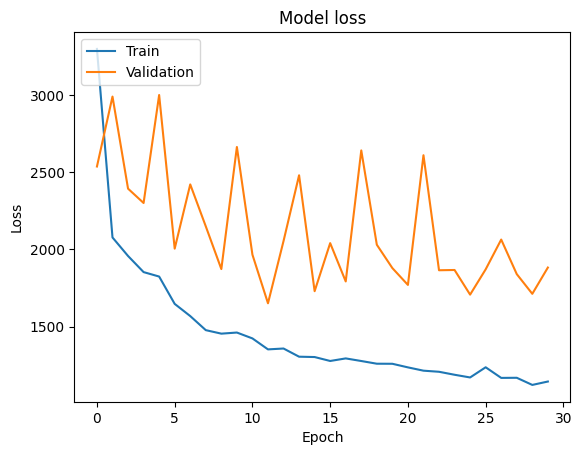

In [ ]:

# Define the model
model = Sequential([
    LSTM(128, activation='relu', return_sequences=False, input_shape=(sequence_length, len(features_to_normalize))),
    Dropout(0.35),
    Dense(32, activation='relu'),
    Dropout(0.35),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Best Configuration: {'learning_rate': 0.001, 'dropout_rate': 0.35, 'epochs': 30, 'batch_size': 16, 'test_loss': 329.05718994140625, 'test_mae': 12.569485664367676}
#early stopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=10)


# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=16)

# plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



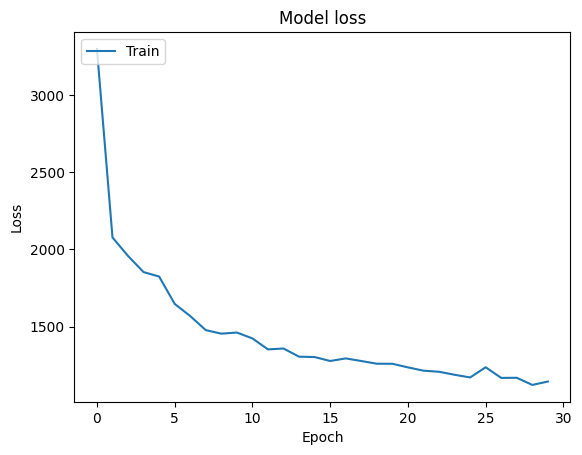

In [ ]:
# plot the training and validation loss
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


4/4 [==============================] - 0s 6ms/step - loss: 380.9750 - mae: 13.6633
Test Loss: 380.9750061035156, Test MAE: 13.663265228271484
4/4 [==============================] - 0s 6ms/step


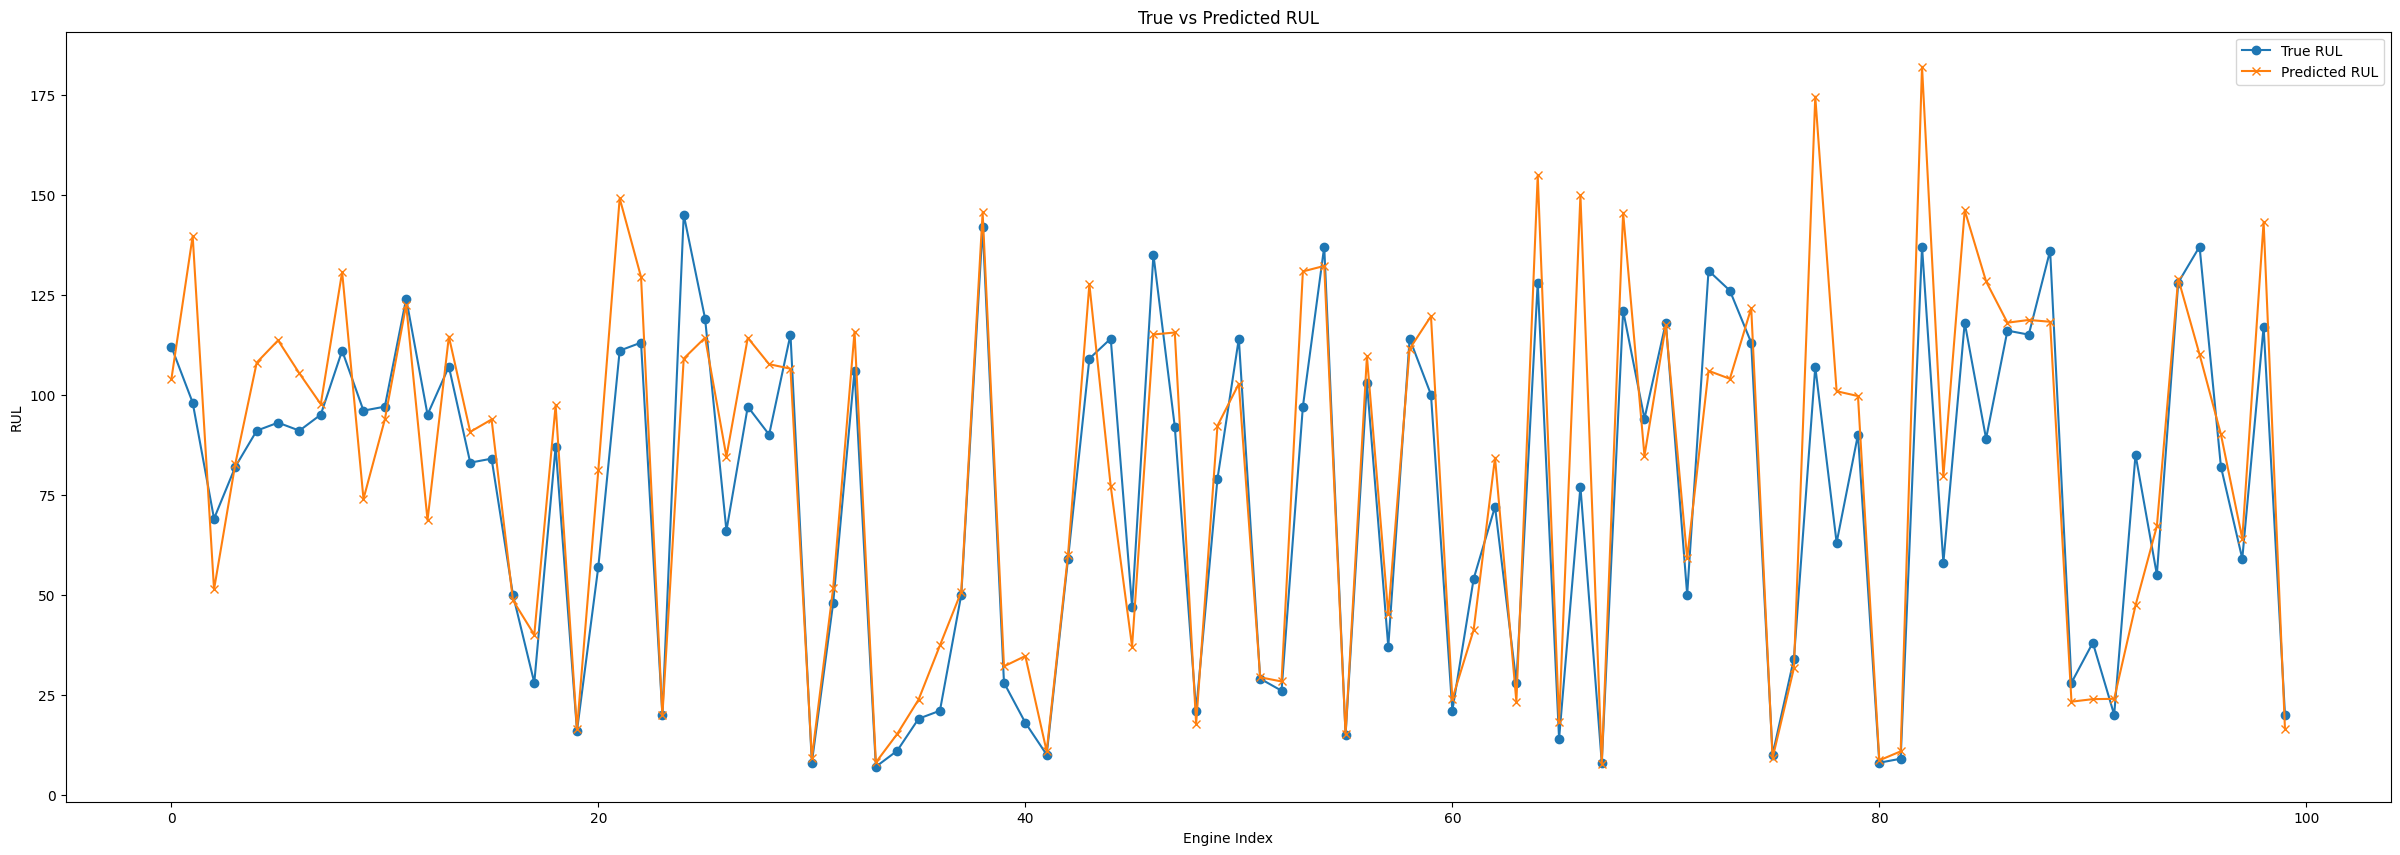

In [ ]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Predict RUL for test data
y_pred = model.predict(X_test)

# Compare predictions with true RUL
plt.figure(figsize=(30, 10))
plt.plot(y_test, label='True RUL', marker='o')
plt.plot(y_pred, label='Predicted RUL', marker='x')
plt.xlabel('Engine Index')
plt.ylabel('RUL')
plt.legend()
plt.title('True vs Predicted RUL')
plt.show()

Model evaluation

4/4 [==============================] - 0s 12ms/step - loss: 524.6462 - mae: 16.5971
Test Loss: 524.6461791992188, Test MAE: 16.597082138061523
4/4 [==============================] - 0s 5ms/step


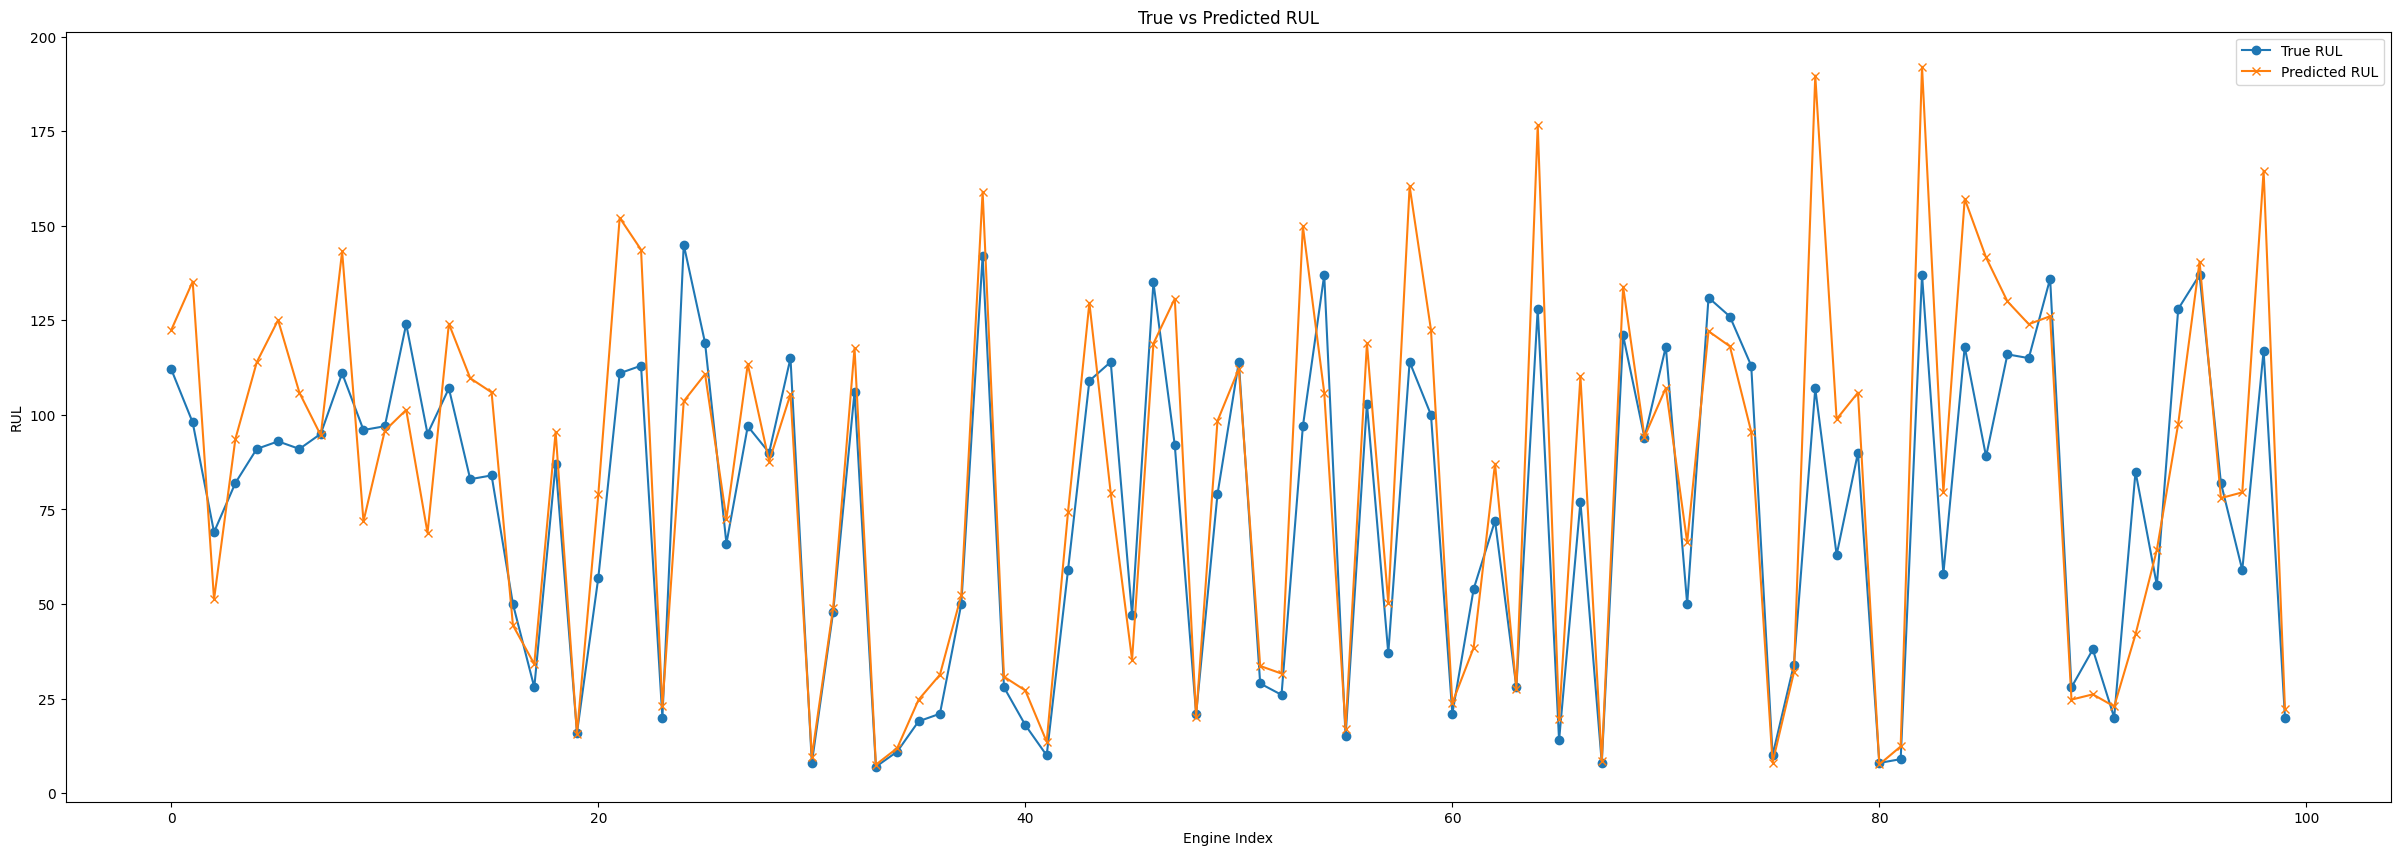

In [ ]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Predict RUL for test data
y_pred = model.predict(X_test)

# Compare predictions with true RUL
plt.figure(figsize=(30, 10))
plt.plot(y_test, label='True RUL', marker='o')
plt.plot(y_pred, label='Predicted RUL', marker='x')
plt.xlabel('Engine Index')
plt.ylabel('RUL')
plt.legend()
plt.title('True vs Predicted RUL')
plt.show()


Testing: LR=0.0001, Dropout=0.2, Epochs=30, Batch Size=16
Test Loss: 549.302978515625, Test MAE: 16.648866653442383
Testing: LR=0.0001, Dropout=0.2, Epochs=30, Batch Size=32
Test Loss: 668.2491455078125, Test MAE: 18.913406372070312
Testing: LR=0.0001, Dropout=0.2, Epochs=30, Batch Size=64
Test Loss: 1632.4847412109375, Test MAE: 32.53788757324219
Testing: LR=0.0001, Dropout=0.2, Epochs=30, Batch Size=128
Test Loss: 1573.9681396484375, Test MAE: 32.761329650878906
Testing: LR=0.0001, Dropout=0.2, Epochs=50, Batch Size=16
Test Loss: 749.8563842773438, Test MAE: 20.5543270111084
Testing: LR=0.0001, Dropout=0.2, Epochs=50, Batch Size=32
Test Loss: 889.1143188476562, Test MAE: 22.508756637573242
Testing: LR=0.0001, Dropout=0.2, Epochs=50, Batch Size=64
Test Loss: 983.356689453125, Test MAE: 24.563505172729492
Testing: LR=0.0001, Dropout=0.2, Epochs=50, Batch Size=128
Test Loss: 974.8941650390625, Test MAE: 22.784893035888672
Testing: LR=0.0001, Dropout=0.2, Epochs=100, Batch Size=16
Test L

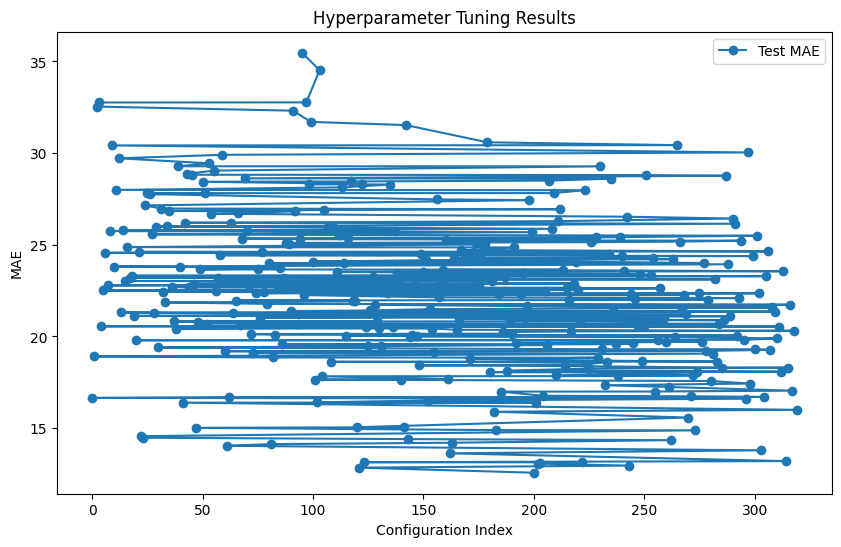

In [ ]:
# Hyperparameter Tuning
# Define a function to build the model
def build_model(learning_rate, dropout_rate):
    model = Sequential([
        LSTM(128, activation='relu', return_sequences=False, input_shape=(sequence_length, len(features_to_normalize))),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005],
    'dropout_rate': [0.2, 0.3,0.35, 0.4],
    'epochs': [30, 50, 100, 150, 200],
    'batch_size': [16, 32, 64,128]
}

# To store the results
results = []

# Grid search
for learning_rate in param_grid['learning_rate']:
    for dropout_rate in param_grid['dropout_rate']:
        for epochs in param_grid['epochs']:
            for batch_size in param_grid['batch_size']:
                print(f"Testing: LR={learning_rate}, Dropout={dropout_rate}, Epochs={epochs}, Batch Size={batch_size}")

                # Build the model
                model = build_model(learning_rate, dropout_rate)

                # Early stopping callback
                early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

                # Train the model
                history = model.fit(
                    X_train, y_train,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0,
                    callbacks=[early_stopping]
                )

                # Evaluate on test set
                test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

                # Save results
                results.append({
                    'learning_rate': learning_rate,
                    'dropout_rate': dropout_rate,
                    'epochs': epochs,
                    'batch_size': batch_size,
                    'test_loss': test_loss,
                    'test_mae': test_mae
                })
                print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Find the best configuration
best_config = min(results, key=lambda x: x['test_mae'])
print(f"Best Configuration: {best_config}")


results_df = pd.DataFrame(results)
results_df.sort_values(by='test_mae', inplace=True)
plt.figure(figsize=(10, 6))
plt.plot(results_df['test_mae'], label='Test MAE', marker='o')
plt.xlabel('Configuration Index')
plt.ylabel('MAE')
plt.title('Hyperparameter Tuning Results')
plt.legend()
plt.show()


## Active learning

In [ ]:
# Step 1: Simulate Initial Labeled and Unlabeled Data
initial_labeled_fraction = 0.3 # 30% of the training data will be labeled initially
initial_labeled_indices = np.random.choice(len(X_train), size=int(len(X_train) * initial_labeled_fraction), replace=False)
X_labeled = X_train[initial_labeled_indices]
y_labeled = y_train[initial_labeled_indices]

unlabeled_indices = list(set(range(len(X_train))) - set(initial_labeled_indices))
X_unlabeled = X_train[unlabeled_indices]
y_unlabeled = y_train[unlabeled_indices]

print(f"Initial Labeled Data: {X_labeled.shape}")
print(f"Initial Unlabeled Data: {X_unlabeled.shape}")

# Step 2: Define the Model with Dropout
def build_model():
    model = Sequential([
        LSTM(128, activation='relu', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.35),
        Dense(32, activation='relu'),
        Dropout(0.35),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model


Initial Labeled Data: (5289, 30, 24)
Initial Unlabeled Data: (12342, 30, 24)



Active Learning Iteration 1/10
Epoch 1/30
265/265 [==============================] - 6s 13ms/step - loss: 7952.7402 - mae: 67.8196 - val_loss: 2051.3674 - val_mae: 32.9886
Epoch 2/30
265/265 [==============================] - 3s 11ms/step - loss: 2925.4087 - mae: 39.5821 - val_loss: 1629.0239 - val_mae: 30.5302
Epoch 3/30
265/265 [==============================] - 3s 11ms/step - loss: 2671.2266 - mae: 37.6799 - val_loss: 1720.0145 - val_mae: 30.7377
Epoch 4/30
265/265 [==============================] - 3s 11ms/step - loss: 2576.3887 - mae: 37.1953 - val_loss: 1793.3641 - val_mae: 31.0812
Epoch 5/30
265/265 [==============================] - 3s 11ms/step - loss: 2678.8171 - mae: 37.7410 - val_loss: 1548.5219 - val_mae: 29.6340
Epoch 6/30
265/265 [==============================] - 3s 11ms/step - loss: 2331.8245 - mae: 35.4893 - val_loss: 2505.0728 - val_mae: 36.5006
Epoch 7/30
265/265 [==============================] - 3s 11ms/step - loss: 2443.7981 - mae: 35.9859 - val_loss: 1714.5172 

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Labeled Data Size: 5319
Unlabeled Data Size: 12312

Active Learning Iteration 2/10
Epoch 1/30
266/266 [==============================] - 6s 13ms/step - loss: 6577.9785 - mae: 59.9116 - val_loss: 2258.1968 - val_mae: 35.3139
Epoch 2/30
266/266 [==============================] - 3s 12ms/step - loss: 2802.1545 - mae: 38.9922 - val_loss: 1673.9414 - val_mae: 31.4382
Epoch 3/30
266/266 [==============================] - 3s 12ms/step - loss: 2508.4741 - mae: 36.7327 - val_loss: 1777.2380 - val_mae: 32.2759
Epoch 4/30
266/266 [==============================] - 4s 14ms/step - loss: 2450.0837 - mae: 35.9896 - val_loss: 1583.0065 - val_mae: 29.4497
Epoch 5/30
266/266 [==============================] - 4s 14ms/step - loss: 2352.4685 - mae: 35.5367 - val_loss: 2137.1343 - val_mae: 33.8995
Epoch 6/30
266/266 [==============================] - 4s 13ms/step - loss: 2307.9543 - mae: 34.5610 - val_loss: 1691.0906 - val_mae: 29.7960
Epoch 7/30
266/266 [==============================] - 4s 13ms/step - lo

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/30
268/268 [==============================] - 5s 13ms/step - loss: 5137.9805 - mae: 52.6273 - val_loss: 2277.7449 - val_mae: 34.9275
Epoch 2/30
268/268 [==============================] - 3s 12ms/step - loss: 2770.5383 - mae: 38.3318 - val_loss: 1702.6456 - val_mae: 31.1193
Epoch 3/30
268/268 [==============================] - 3s 12ms/step - loss: 2692.5193 - mae: 38.3660 - val_loss: 1693.9805 - val_mae: 31.7331
Epoch 4/30
268/268 [==============================] - 3s 12ms/step - loss: 2641.1155 - mae: 37.2797 - val_loss: 1709.7268 - val_mae: 30.9232
Epoch 5/30
268/268 [==============================] - 3s 12ms/step - loss: 2464.9495 - mae: 36.4392 - val_loss: 1613.5746 - val_mae: 30.7471
Epoch 6/30
268/268 [==============================] - 3s 12ms/step - loss: 2505.7949 - mae: 36.7787 - val_loss: 1612.5704 - val_mae: 30.3738
Epoch 7/30
268/268 [==============================] - 3s 12ms/step - loss: 2842.2588 - mae: 38.7646 - val_loss: 1757.2064 - val_mae: 32.8134
Epoch 8/30
26

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/30
269/269 [==============================] - 5s 13ms/step - loss: 4380.4355 - mae: 48.8944 - val_loss: 2573.8396 - val_mae: 37.5096
Epoch 2/30
269/269 [==============================] - 3s 12ms/step - loss: 2879.8999 - mae: 39.5403 - val_loss: 1681.8351 - val_mae: 31.2896
Epoch 3/30
269/269 [==============================] - 3s 12ms/step - loss: 2653.6321 - mae: 37.6842 - val_loss: 1718.4845 - val_mae: 31.4075
Epoch 4/30
269/269 [==============================] - 3s 12ms/step - loss: 2503.3411 - mae: 36.6459 - val_loss: 1933.7557 - val_mae: 32.1601
Epoch 5/30
269/269 [==============================] - 3s 12ms/step - loss: 2637.7578 - mae: 37.9607 - val_loss: 1668.5599 - val_mae: 31.5477
Epoch 6/30
269/269 [==============================] - 3s 12ms/step - loss: 2410.1030 - mae: 36.0557 - val_loss: 1684.8732 - val_mae: 30.3499
Epoch 7/30
269/269 [==============================] - 3s 12ms/step - loss: 2365.4700 - mae: 35.3996 - val_loss: 1919.1901 - val_mae: 31.8862
Epoch 8/30
26

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Labeled Data Size: 5409
Unlabeled Data Size: 12222

Active Learning Iteration 5/10
Epoch 1/30
271/271 [==============================] - 10s 19ms/step - loss: 5895.8027 - mae: 57.0475 - val_loss: 1904.3005 - val_mae: 33.5128
Epoch 2/30
271/271 [==============================] - 4s 16ms/step - loss: 2829.8726 - mae: 39.1047 - val_loss: 1943.2983 - val_mae: 32.2853
Epoch 3/30
271/271 [==============================] - 4s 16ms/step - loss: 2680.3074 - mae: 37.7779 - val_loss: 1738.4081 - val_mae: 32.0277
Epoch 4/30
271/271 [==============================] - 4s 16ms/step - loss: 2650.0359 - mae: 37.3882 - val_loss: 1723.5483 - val_mae: 32.0803
Epoch 5/30
271/271 [==============================] - 4s 16ms/step - loss: 2595.7500 - mae: 37.3773 - val_loss: 1723.6840 - val_mae: 30.8777
Epoch 6/30
271/271 [==============================] - 4s 16ms/step - loss: 2486.1196 - mae: 36.2734 - val_loss: 1833.2991 - val_mae: 31.1717
Epoch 7/30
271/271 [==============================] - 4s 15ms/step - l

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/30
272/272 [==============================] - 7s 15ms/step - loss: 4093.6621 - mae: 46.7834 - val_loss: 2918.3650 - val_mae: 39.9663
Epoch 2/30
272/272 [==============================] - 4s 13ms/step - loss: 2651.4614 - mae: 37.8687 - val_loss: 1723.7136 - val_mae: 31.8429
Epoch 3/30
272/272 [==============================] - 4s 13ms/step - loss: 2541.3159 - mae: 36.6504 - val_loss: 1920.1830 - val_mae: 32.0090
Epoch 4/30
272/272 [==============================] - 4s 13ms/step - loss: 2469.4595 - mae: 36.1018 - val_loss: 1678.8346 - val_mae: 31.6071
Epoch 5/30
272/272 [==============================] - 4s 14ms/step - loss: 2382.2832 - mae: 35.5081 - val_loss: 1501.5355 - val_mae: 29.2946
Epoch 6/30
272/272 [==============================] - 4s 14ms/step - loss: 2230.0815 - mae: 34.3464 - val_loss: 1465.4318 - val_mae: 28.6087
Epoch 7/30
272/272 [==============================] - 4s 15ms/step - loss: 2235.3650 - mae: 34.2609 - val_loss: 1601.1498 - val_mae: 29.7369
Epoch 8/30
27

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Labeled Data Size: 5469
Unlabeled Data Size: 12162

Active Learning Iteration 7/10
Epoch 1/30
274/274 [==============================] - 8s 19ms/step - loss: 4221.5630 - mae: 47.7537 - val_loss: 2122.7058 - val_mae: 33.8947
Epoch 2/30
274/274 [==============================] - 5s 18ms/step - loss: 2745.4893 - mae: 38.4370 - val_loss: 1926.8284 - val_mae: 32.4127
Epoch 3/30
274/274 [==============================] - 5s 17ms/step - loss: 2560.3413 - mae: 36.9526 - val_loss: 4202.9727 - val_mae: 50.2515
Epoch 4/30
274/274 [==============================] - 5s 18ms/step - loss: 2631.9302 - mae: 37.5172 - val_loss: 1692.3967 - val_mae: 30.8910
Epoch 5/30
274/274 [==============================] - 5s 17ms/step - loss: 2563.6985 - mae: 37.0452 - val_loss: 1811.1837 - val_mae: 31.7611
Epoch 6/30
274/274 [==============================] - 5s 17ms/step - loss: 2450.8054 - mae: 36.2379 - val_loss: 1989.8711 - val_mae: 33.2673
Epoch 7/30
274/274 [==============================] - 5s 17ms/step - lo

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/30
275/275 [==============================] - 7s 15ms/step - loss: 4991.1401 - mae: 52.8604 - val_loss: 1914.7023 - val_mae: 32.6580
Epoch 2/30
275/275 [==============================] - 4s 13ms/step - loss: 2634.1138 - mae: 38.1376 - val_loss: 2063.6521 - val_mae: 33.3117
Epoch 3/30
275/275 [==============================] - 4s 13ms/step - loss: 2617.0544 - mae: 37.4974 - val_loss: 1684.4702 - val_mae: 30.8465
Epoch 4/30
275/275 [==============================] - 4s 14ms/step - loss: 2488.1831 - mae: 36.9881 - val_loss: 1619.6344 - val_mae: 30.8626
Epoch 5/30
275/275 [==============================] - 4s 15ms/step - loss: 2440.9673 - mae: 36.1108 - val_loss: 1560.0864 - val_mae: 29.9716
Epoch 6/30
275/275 [==============================] - 4s 15ms/step - loss: 2280.6680 - mae: 35.2725 - val_loss: 1572.8904 - val_mae: 30.0693
Epoch 7/30
275/275 [==============================] - 4s 15ms/step - loss: 2331.3342 - mae: 35.1955 - val_loss: 1685.2700 - val_mae: 32.2144
Epoch 8/30
27

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/30
277/277 [==============================] - 6s 14ms/step - loss: 5224.7617 - mae: 52.9642 - val_loss: 1818.2240 - val_mae: 32.4534
Epoch 2/30
277/277 [==============================] - 4s 13ms/step - loss: 2867.5667 - mae: 39.3205 - val_loss: 1712.4381 - val_mae: 31.6973
Epoch 3/30
277/277 [==============================] - 4s 13ms/step - loss: 2600.2268 - mae: 37.4606 - val_loss: 2309.4619 - val_mae: 35.4314
Epoch 4/30
277/277 [==============================] - 4s 13ms/step - loss: 2562.8091 - mae: 37.2373 - val_loss: 2056.7148 - val_mae: 33.4256
Epoch 5/30
277/277 [==============================] - 4s 13ms/step - loss: 2457.1025 - mae: 36.2571 - val_loss: 2058.4104 - val_mae: 36.2281
Epoch 6/30
277/277 [==============================] - 4s 13ms/step - loss: 2407.0471 - mae: 35.6454 - val_loss: 2439.4919 - val_mae: 36.3652
Epoch 7/30
4/4 [==============================] - 0s 7ms/step - loss: 1174.7164 - mae: 26.7519
Test Loss: 1174.7164306640625, Test MAE: 26.75189971923828


/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/30
278/278 [==============================] - 6s 14ms/step - loss: 4058.6653 - mae: 46.6792 - val_loss: 1889.4274 - val_mae: 34.2879
Epoch 2/30
278/278 [==============================] - 4s 13ms/step - loss: 2839.2942 - mae: 39.1468 - val_loss: 2004.8031 - val_mae: 35.7797
Epoch 3/30
278/278 [==============================] - 3s 13ms/step - loss: 2616.1467 - mae: 37.6750 - val_loss: 1833.9167 - val_mae: 31.9793
Epoch 4/30
278/278 [==============================] - 3s 13ms/step - loss: 2650.3044 - mae: 38.0173 - val_loss: 1723.4410 - val_mae: 31.3134
Epoch 5/30
278/278 [==============================] - 3s 13ms/step - loss: 2558.2458 - mae: 36.9688 - val_loss: 1710.9865 - val_mae: 32.1980
Epoch 6/30
278/278 [==============================] - 4s 13ms/step - loss: 2541.8711 - mae: 36.9064 - val_loss: 1686.3774 - val_mae: 31.4534
Epoch 7/30
278/278 [==============================] - 4s 13ms/step - loss: 2346.5457 - mae: 35.4542 - val_loss: 1843.6733 - val_mae: 31.4146
Epoch 8/30
27

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


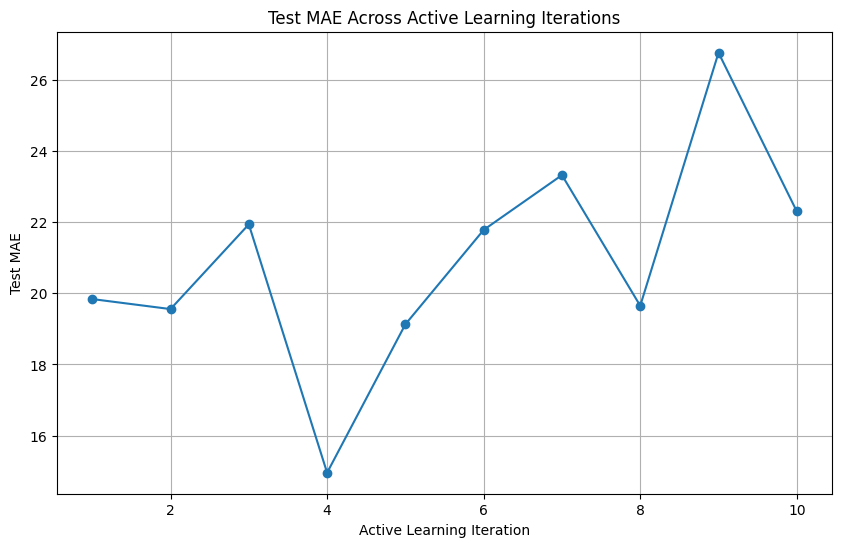

Best Active Learning Result: Iteration 4, Test MAE: 14.960411071777344


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# Active Learning Loop
iterations = 10  # Number of AL iterations
samples_per_iteration = 30  # Number of samples to select per iteration could be increased for better results
results = []  # To store results

for iteration in range(iterations):
    print(f"\nActive Learning Iteration {iteration + 1}/{iterations}")

    # Step 3: Train the Model on Labeled Data
    model = build_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_labeled, y_labeled,
        validation_split=0.2,
        epochs=30,
        batch_size=16,
        verbose=1,
        callbacks=[early_stopping]
    )

    # Evaluate on the test set
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")
    results.append({'iteration': iteration + 1, 'test_loss': test_loss, 'test_mae': test_mae})

    # Step 4: Monte Carlo Dropout for Uncertainty Estimation
    num_samples = 50  # Number of samples for Monte Carlo Dropout estimation (can be increased for better uncertainty estimation)
    y_preds = np.array([model.predict(X_unlabeled, verbose=0) for _ in range(num_samples)])
    uncertainties = y_preds.var(axis=0).flatten()  # Variance as uncertainty metric

    # Step 5: Select Most Uncertain Samples
    most_uncertain_indices = np.argsort(uncertainties)[-samples_per_iteration:]
    X_uncertain = X_unlabeled[most_uncertain_indices]
    y_uncertain = y_unlabeled[most_uncertain_indices]

    # Step 6: Filter for Diversity
    # Compute cosine similarity to ensure diversity
    available_samples = len(most_uncertain_indices)

    # Debugging: Check sizes
    print(f"most_uncertain_indices size: {available_samples}")
    print(f"X_uncertain shape: {X_uncertain.shape}")

    # Dynamically adjust samples_per_iteration if needed
    if samples_per_iteration > available_samples:
        print(f"Reducing samples_per_iteration from {samples_per_iteration} to {available_samples}")
        samples_per_iteration = available_samples

    # Compute cosine similarity
    similarity_matrix = cosine_similarity(X_uncertain.reshape(available_samples, -1))
    print(f"similarity_matrix shape: {similarity_matrix.shape}")

    # Select diverse samples
    if samples_per_iteration == available_samples:
        # If the number of samples matches, take all
        diverse_indices = np.arange(available_samples)
    else:
        # Otherwise, select diverse samples
        diverse_indices = np.argpartition(similarity_matrix.sum(axis=1), samples_per_iteration)[:samples_per_iteration]

    # Final indices for selected samples
    final_indices = most_uncertain_indices[diverse_indices]
    X_selected = X_unlabeled[final_indices]
    y_selected = y_unlabeled[final_indices]



Best Active Learning Result: Iteration 4, Test MAE: 14.960411071777344
![image.png](attachment:image.png)


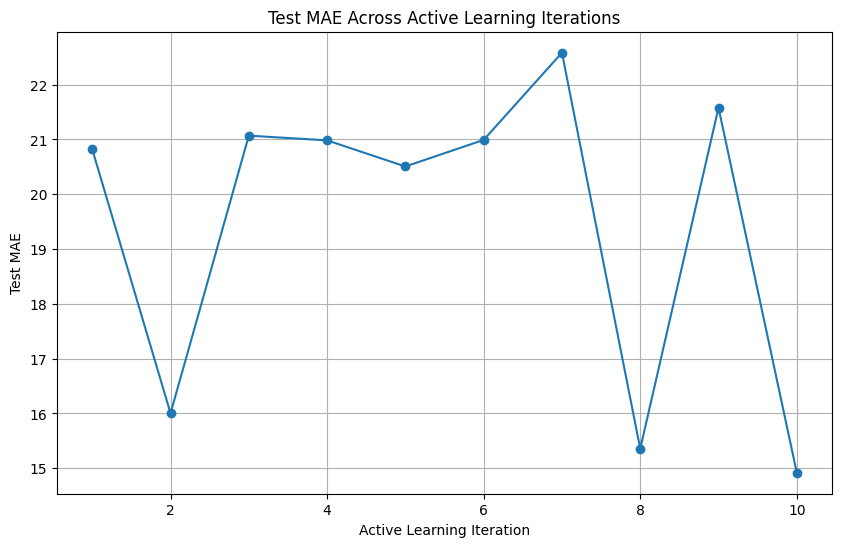

Best Active Learning Result: Iteration 10, Test MAE: 14.919049263000488


In [ ]:

# Step 7: Visualize Results
iterations = [result['iteration'] for result in results]
test_maes = [result['test_mae'] for result in results]

plt.figure(figsize=(10, 6))
plt.plot(iterations, test_maes, marker='o')
plt.xlabel('Active Learning Iteration')
plt.ylabel('Test MAE')
plt.title('Test MAE Across Active Learning Iterations')
plt.grid()
plt.show()

# Final Evaluation
best_result = min(results, key=lambda x: x['test_mae'])
print(f"Best Active Learning Result: Iteration {best_result['iteration']}, Test MAE: {best_result['test_mae']}")


4/4 [==============================] - 0s 10ms/step


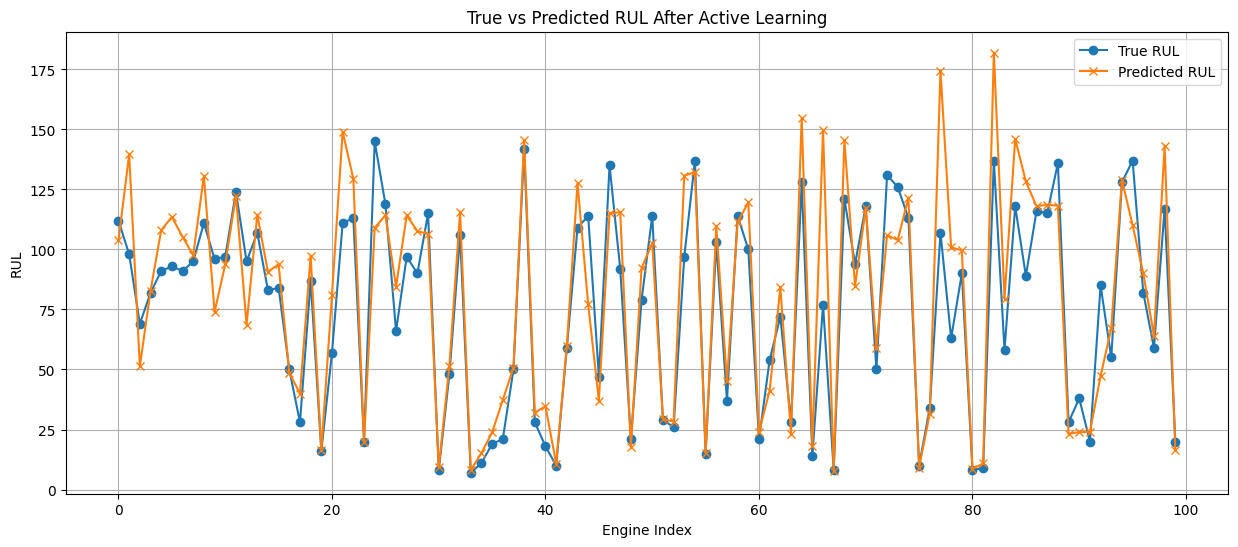

In [ ]:
# Final Evaluation: Compare Predictions with True RUL
# Predict RUL on the test set
y_pred_final = model.predict(X_test).flatten()  # Flatten to 1D if necessary

# Visualize True RUL vs Predicted RUL
plt.figure(figsize=(15, 6))  # Adjust the size to fit better
plt.plot(y_test, label='True RUL', marker='o')
plt.plot(y_pred_final, label='Predicted RUL', marker='x')
plt.xlabel('Engine Index')
plt.ylabel('RUL')
plt.legend()
plt.title('True vs Predicted RUL After Active Learning')
plt.grid(True)
plt.show()


In [70]:
def make_prior_fn():
    return tfp.layers.default_multivariate_normal_fn

def make_posterior_fn():
    return tfp.layers.default_mean_field_normal_fn

def objective(trial):
    # Debug data shapes
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")

    # Suggest hyperparameters
    units = trial.suggest_categorical('units', [64, 128, 256])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    posterior_samples = trial.suggest_int('posterior_samples', 30, 100)

    # Build the model
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))  # Shape (timesteps, features)
    x = tfp.layers.DenseVariational(
        units=units,
        make_prior_fn=make_prior_fn,
        make_posterior_fn=make_posterior_fn,
        activation='relu'
    )(inputs)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tfp.layers.DenseVariational(
        units=units // 2,
        make_prior_fn=make_prior_fn,
        make_posterior_fn=make_posterior_fn,
        activation='relu'
    )(x)
    outputs = tfp.layers.DenseVariational(
        units=1,
        make_prior_fn=make_prior_fn,
        make_posterior_fn=make_posterior_fn
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse', metrics=['mae'])

    # Train the model
    model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=16, verbose=0)

    # Evaluate the model
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"Trial Test Loss: {test_loss}, Test MAE: {test_mae}")
    return test_mae  # Minimize MAE


In [72]:
print(f"X_train type: {type(X_train)}, shape: {X_train.shape}")
print(f"X_test type: {type(X_test)}, shape: {X_test.shape}")


X_train type: <class 'numpy.ndarray'>, shape: (17631, 30, 24)
X_test type: <class 'numpy.ndarray'>, shape: (100, 30, 24)


In [71]:
import optuna

# Create study
study = optuna.create_study(direction='minimize')  # Minimize Test MAE

# Run optimization
study.optimize(objective, n_trials=50)  # Perform 50 trials

# Print best parameters and result
print("Best Hyperparameters:", study.best_params)
print("Best Test MAE:", study.best_value)


[I 2025-01-10 16:34:41,501] A new study created in memory with name: no-name-c6236de2-9788-4c2e-8e2a-ce7e9fc10907
[W 2025-01-10 16:34:41,508] Trial 0 failed with parameters: {'units': 256, 'dropout_rate': 0.25791888129664714, 'learning_rate': 0.0016844196156395946, 'posterior_samples': 53} because of the following error: AttributeError("'tuple' object has no attribute 'rank'").
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-70-09145e935d7d>", line 22, in objective
    x = tfp.layers.DenseVariational(
  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/input_spec.py", line 251, in assert_input_compatibility
    ndim = x.shape.rank
AttributeError: 'tuple' object has no

X_train shape: (17631, 30, 24)
y_train shape: (17631, 1)
X_test shape: (100, 30, 24)
y_test shape: (100, 1)


AttributeError: 'tuple' object has no attribute 'rank'